# Preparing working environnement

In [1]:
# Importing librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

# Allowing modules autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Pandas options
pd.options.display.max_columns = 100

In [2]:
# Loading data
data = pd.read_pickle('PSanté_03_data_cleaned.pkl')

In [3]:
data.columns

Index(['code', 'product_name', 'generic_name', 'categories', 'categories_tags',
       'categories_en', 'main_category', 'main_category_en', 'pnns_groups_1',
       'pnns_groups_2', 'nutriscore_score', 'nutriscore_grade',
       'energy-kj_100g', 'energy-kcal_100g', 'energy_100g',
       'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g',
       'monounsaturated-fat_100g', 'polyunsaturated-fat_100g',
       'omega-3-fat_100g', '-alpha-linolenic-acid_100g',
       '-eicosapentaenoic-acid_100g', '-docosahexaenoic-acid_100g',
       'omega-6-fat_100g', '-linoleic-acid_100g', 'omega-9-fat_100g',
       'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
       'sugars_100g', '-sucrose_100g', '-glucose_100g', '-fructose_100g',
       '-lactose_100g', 'starch_100g', 'polyols_100g', 'fiber_100g',
       'proteins_100g', 'casein_100g', 'serum-proteins_100g', 'salt_100g',
       'sodium_100g', 'alcohol_100g', 'vitamin-a_100g', 'beta-carotene_100g',
       'vitamin-d_100g', 'vitami

# Exploring nutriscore-related columns

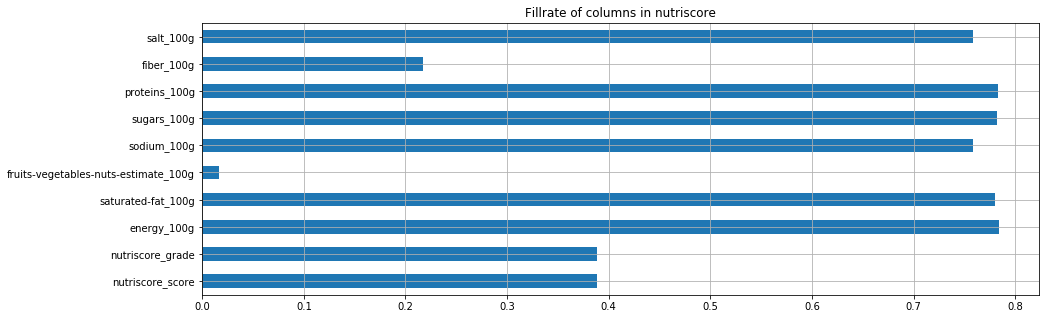

In [4]:
# Useful columns for nutriscore
gr_nutriscore = ['nutriscore_score', 'nutriscore_grade',
                 'energy_100g',
                 'saturated-fat_100g',
                 'fruits-vegetables-nuts-estimate_100g',
                 'sodium_100g',
                 'sugars_100g',
                 'proteins_100g',
                 'fiber_100g',
                 'salt_100g'
                ]

from PSanté_01_scripts import df_fillrates
df_fillrates(data[gr_nutriscore], 'nutriscore', h_size = 15)

Out of the 8 criteria for nutriscore, all have dedicated columns in the dataset and looks availiable in a excellent or decent amount of data. The avaliability of actual grades and scores could be useful for a classifier algorithm.

## Grades and score

In [5]:
# Difference between grade and score
data[~data['nutriscore_grade'].isna()][['nutriscore_grade','nutriscore_score']].head(10)

,nutriscore_grade,nutriscore_score
3,d,18.0
12,b,1.0
19,d,14.0
27,a,-2.0
31,b,1.0
54,d,14.0
56,c,4.0
57,b,0.0
60,a,-4.0
62,d,15.0


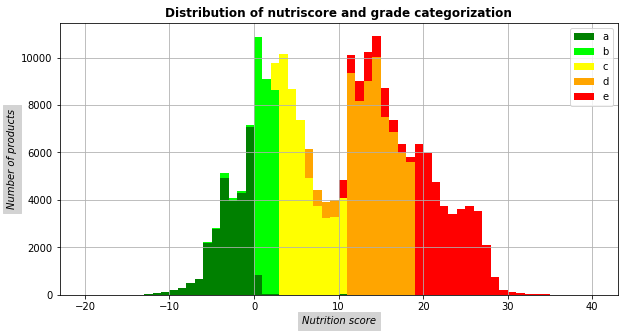

In [6]:
# Plotting link between the score and the grade
from PSanté_01_scripts import grade_distrib
grade_distrib(data, size = (10,5))

The distribution of products regarding their nutriscore score clearly shows a **bimodal distribution**: first peak around a score of 0, and second peak around 14.

At first sight, grades and score seems not to be directly linked, due to overlap area between grades. These overlaps might indicate that the scale between score and grade differs according to the kind of product.

In [7]:
# Limits of each grade
data[['nutriscore_grade','nutriscore_score']].groupby(by = 'nutriscore_grade').agg(['min', 'max'])

nutriscore_score      
                              min   max
nutriscore_grade                       
a                           -15.0  20.0
b                           -10.0   2.0
c                             2.0  10.0
d                             6.0  18.0
e                            10.0  40.0

In [8]:
data[['nutriscore_grade','nutriscore_score']].groupby(by = 'nutriscore_grade').describe()

nutriscore_score                                         \
                            count       mean       std   min   25%   50%   
nutriscore_grade                                                           
a                         28006.0  -3.180747  2.248807 -15.0  -4.0  -3.0   
b                         28253.0   0.858493  1.054951 -10.0   0.0   1.0   
c                         46523.0   5.494379  2.321136   2.0   4.0   5.0   
d                         65820.0  13.783850  2.628054   6.0  12.0  14.0   
e                         45334.0  21.149667  4.231102  10.0  19.0  21.0   

                              
                   75%   max  
nutriscore_grade              
a                 -1.0  20.0  
b                  2.0   2.0  
c                  7.0  10.0  
d                 16.0  18.0  
e                 24.0  40.0

### Investigating the overlap

In [9]:
# Products graded E, whose score is less than 19
data[
    (data['nutriscore_grade'] == 'e') & 
    (data['nutriscore_score'] < 19)
]['main_category'].value_counts()

en:beverages                   5803
en:fruit-juices-and-nectars     751
en:fruit-juices                 256
en:groceries                      2
Name: main_category, dtype: int64

In [10]:
# Products graded D, whose score is less than 10
data[
    (data['nutriscore_grade'] == 'd') & 
    (data['nutriscore_score'] < 10)
]['main_category'].value_counts()

en:beverages                   2635
en:fruit-juices                 596
en:fruit-juices-and-nectars      82
en:groceries                      1
Name: main_category, dtype: int64

In [11]:
# Products graded A, whose score is more than 0
data[
    (data['nutriscore_grade'] == 'a') & 
    (data['nutriscore_score'] >= 0)
]['main_category'].value_counts()

en:beverages    963
Name: main_category, dtype: int64

In [12]:
# Products graded B, whose score is less than 0
data[
    (data['nutriscore_grade'] == 'b') & 
    (data['nutriscore_score'] < 0)
]['main_category'].value_counts()

en:fruit-juices    386
en:beverages       201
Name: main_category, dtype: int64

It looks like correspondance between score and grade depends on wether the products is a liquid or a solid aliment

### Splitting solid and liquid products

In [13]:
# Definition of solid and liquid categories
categ_liq = data[
    (data['nutriscore_grade'] == 'e') & 
    (data['nutriscore_score'] < 19)
]['main_category'].unique()[0:3]

categ_sol = [categ for categ in data['main_category'].unique() if categ not in categ_liq]

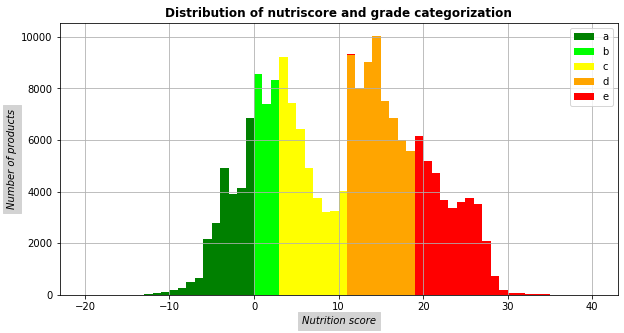

In [14]:
# Score distribution for solid products
grade_distrib(data[data['main_category'].isin(categ_sol)], size = (10,5))

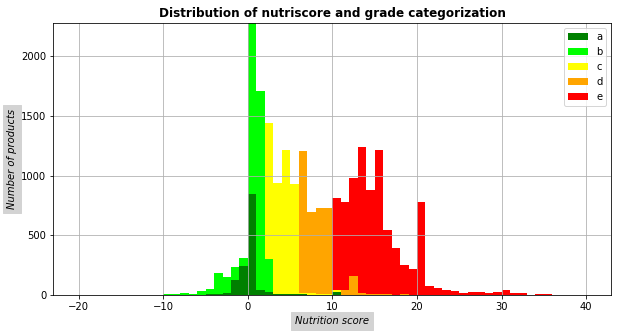

In [15]:
# Score distribution for liquid products
grade_distrib(data[data['main_category'].isin(categ_liq)], size = (10,5))

The overlap has disapeared for solid products, but remains present for liquids

In [16]:
# Liquid products graded from A to D, whose score is more than 10
data[
    (data['main_category'].isin(categ_liq)) &
    (data['nutriscore_grade'] != 'e') & 
    (data['nutriscore_score'] > 10)
][['product_name', 'categories', 'main_category','pnns_groups_1','pnns_groups_2']]

,product_name,categories,main_category,pnns_groups_1,pnns_groups_2
2839,Lait de coco,Laits de coco,en:beverages,Beverages,Plant-based milk substitutes
16418,Coconut milk,"Aliments et boissons à base de végétaux,Boisso...",en:beverages,Beverages,Plant-based milk substitutes
16419,Coconut Milk,"Plant-based foods and beverages, Beverages, Pl...",en:beverages,Beverages,Plant-based milk substitutes
16429,Lait de coco,"Aliments et boissons à base de végétaux, Boiss...",en:beverages,Beverages,Plant-based milk substitutes
16433,Lait de coco,"Aliments et boissons à base de végétaux, Boiss...",en:beverages,Beverages,Plant-based milk substitutes
68166,Coconut Milk,"Aliments et boissons à base de végétaux,Boisso...",en:beverages,Beverages,Plant-based milk substitutes
68888,Lait de coco,en:coconut-milks,en:beverages,Beverages,Plant-based milk substitutes
79251,Lait De Coco,"Aliments et boissons à base de végétaux,Boisso...",en:beverages,Beverages,Plant-based milk substitutes
79306,Lait partiellement écrémé au chocolat,"Boissons, Produits laitiers, Boissons lactées,...",en:beverages,Milk and dairy products,Milk and yogurt
106556,Lait de coco,Laits de coco,en:beverages,Beverages,Plant-based milk substitutes


Products based on coconut milk are categorized as beverages, but seem to follow the solid products rules

In [17]:
# Liquid products graded A
data[
    (data['main_category'].isin(categ_liq)) &
    (data['nutriscore_grade'] == 'a')][['product_name', 'categories', 'main_category','pnns_groups_1','pnns_groups_2']].sample(10)

,product_name,categories,main_category,pnns_groups_1,pnns_groups_2
704745,Soja drink natur,fr:Boissons végétales de soja nature,en:beverages,Beverages,Plant-based milk substitutes
1017900,Fuente arquillo,Aguas de manantial,en:beverages,Beverages,Waters and flavored waters
409170,Ondine eau de source,"Boissons, Eaux, Eaux de sources, Eaux minérales",en:beverages,Beverages,Waters and flavored waters
950416,Vichy catalan 1881,"Bebidas, Aguas, Bebidas carbonatadas, Aguas de...",en:beverages,Beverages,Waters and flavored waters
520365,Sportéus saveur Vanille,"Boissons, Produits laitiers, Boissons lactées,...",en:beverages,Milk and dairy products,Milk and yogurt
503615,Eau de source,en:spring-waters,en:beverages,Beverages,Waters and flavored waters
832439,Eau minerale,"Boissons, Eaux, Eaux de sources, Eaux minérale...",en:beverages,Beverages,Waters and flavored waters
525504,Eau de source de montagne source Roche des écrins,"Boissons, Eaux, Eaux de sources, Boissons sans...",en:beverages,Beverages,Waters and flavored waters
366152,Eau EVIAN,"Boissons, Eaux, Eaux de sources, Eaux minérales",en:beverages,Beverages,Waters and flavored waters
1077961,Dasani,Eau minérale naturelle,en:beverages,Beverages,Waters and flavored waters


In [18]:
# Ranks for categories of liquid products
df_group_liquid = data[
    (data['main_category'].isin(categ_liq)) & (data['nutriscore_score'] < 1)][
    ['product_name','nutriscore_grade','pnns_groups_2']].groupby(by = ['nutriscore_grade', 'pnns_groups_2'], as_index = False).count()

df_group_liquid.pivot(index = 'pnns_groups_2', columns = 'nutriscore_grade', values = 'product_name')

nutriscore_grade,a,b
pnns_groups_2,,
Artificially sweetened beverages,NaN,147.0
Chocolate products,3.0,1.0
Fruit juices,2.0,417.0
Milk and yogurt,109.0,116.0
One-dish meals,1.0,1.0
Plant-based milk substitutes,271.0,328.0
Soups,NaN,1.0
Sweetened beverages,NaN,39.0
Teas and herbal teas and coffees,NaN,9.0


In [19]:
# Liquid products graded B but with a score > 1
data[
    (data['main_category'].isin(categ_liq)) &
    (data['nutriscore_grade'] == 'b') & 
    (data['nutriscore_score'] > 1)
][['product_name', 'categories', 'main_category','pnns_groups_1','pnns_groups_2']]

,product_name,categories,main_category,pnns_groups_1,pnns_groups_2
27122,Lait d'amandes,"Aliments et boissons à base de végétaux, Boiss...",en:beverages,Beverages,Plant-based milk substitutes
29361,Nesquik Chocolate Milk,en:chocolate-milks,en:beverages,Milk and dairy products,Milk and yogurt
110019,coconut & cocoa drink,Plant milks,en:beverages,Beverages,Plant-based milk substitutes
159834,Boisson au riz nature La Vie Claire,"Aliments et boissons à base de végétaux, Boiss...",en:beverages,Beverages,Plant-based milk substitutes
230477,Natural vanilla flavored pudding,"Boissons, Produits laitiers, Produits fermenté...",en:beverages,Milk and dairy products,Milk and yogurt
252936,Yop vanille,"Boissons, Produits laitiers, Produits fermenté...",en:beverages,Milk and dairy products,Milk and yogurt
254013,"Mini Yop, Goût Fraise","Boissons, Produits laitiers, Produits fermenté...",en:beverages,Milk and dairy products,Milk and yogurt
254297,Mon Bio à Boire à la paille Fraise-Mûre,"Boissons, Produits laitiers, Produits fermenté...",en:beverages,Milk and dairy products,Milk and yogurt
254753,Boisson lactée à base de yaourt aromatisée fra...,"Boissons, Produits laitiers, Produits fermenté...",en:beverages,Milk and dairy products,Milk and yogurt
256421,Yaourt à boire aux fraises mixées YOgourmand,"Boissons, Produits laitiers, Produits fermenté...",en:beverages,Milk and dairy products,Milk and yogurt


#### Changing category of coconut milk

In [20]:
# Changing the main category for coconut milk products
mask = data['product_name'].str.contains(r"[Ll]ait [Dd]e [Cc]oco|[Cc]oconut [Mm]ilk", na = False)
data.loc[mask, 'main_category'] = 'en:dairies'

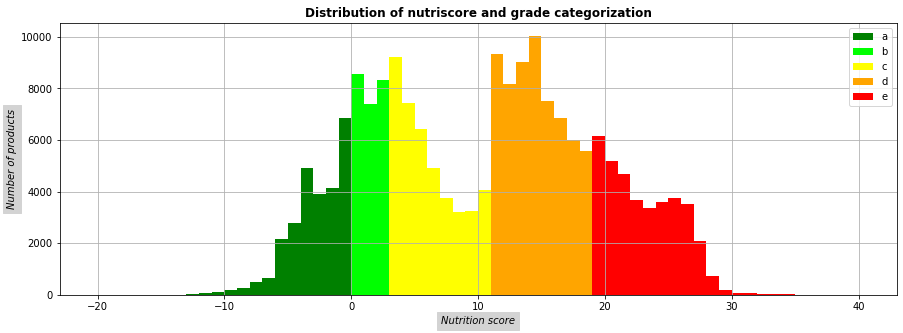

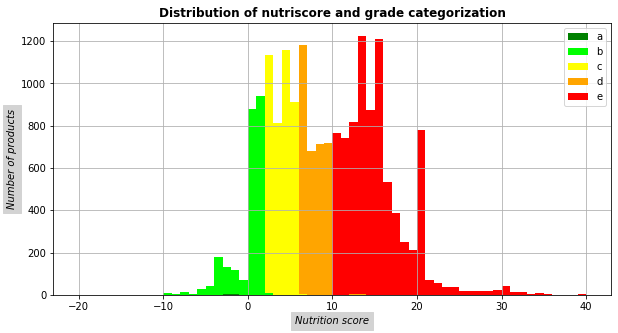

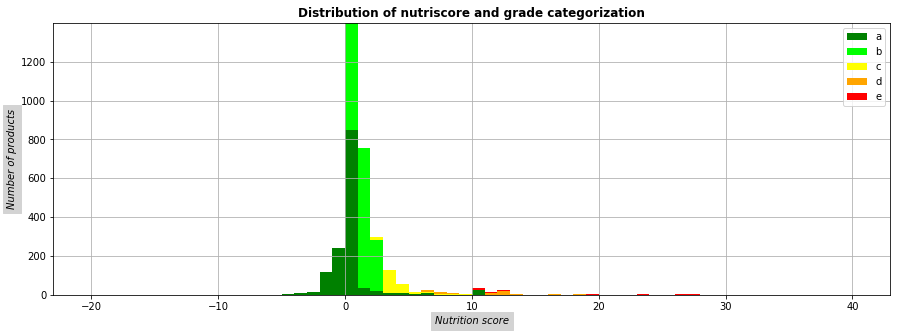

In [21]:
# Score distribution for solid products, including coconut milk
grade_distrib(data[data['main_category'].isin(categ_sol)])

# Score distribution for liquid products, excluding coconut milk and waters
grade_distrib(data[(data['main_category'].isin(categ_liq)) & 
                   (~data['pnns_groups_2'].isin(['Waters and flavored waters', 'Milk and yogurt', 'Plant-based milk substitutes']))], size = (10,5))

# Score distribution for Waters
grade_distrib(data[(data['main_category'].isin(categ_liq)) & 
                   (data['pnns_groups_2'].isin(['Waters and flavored waters', 'Milk and yogurt', 'Plant-based milk substitutes']))])

## Differences between nutriscores

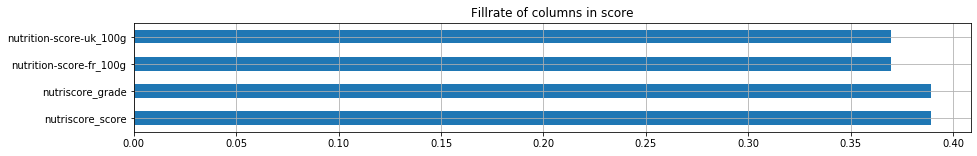

In [22]:
# Scores columns
from PSanté_01_scripts import list_criteria
list_criteria (data, 'score')

In [23]:
data[['nutriscore_grade','nutriscore_score', 'nutrition-score-uk_100g', 'nutrition-score-fr_100g']].sample(10)

,nutriscore_grade,nutriscore_score,nutrition-score-uk_100g,nutrition-score-fr_100g
1026404,c,4.0,0.0,4.0
500463,NaN,NaN,NaN,NaN
379911,NaN,NaN,NaN,NaN
586130,a,-4.0,-4.0,-4.0
530952,NaN,NaN,NaN,NaN
887371,d,11.0,11.0,11.0
525528,NaN,NaN,NaN,NaN
805838,NaN,NaN,NaN,NaN
785264,NaN,NaN,NaN,NaN
960499,NaN,NaN,NaN,NaN


### Nutriscore vs nutrition-score-fr

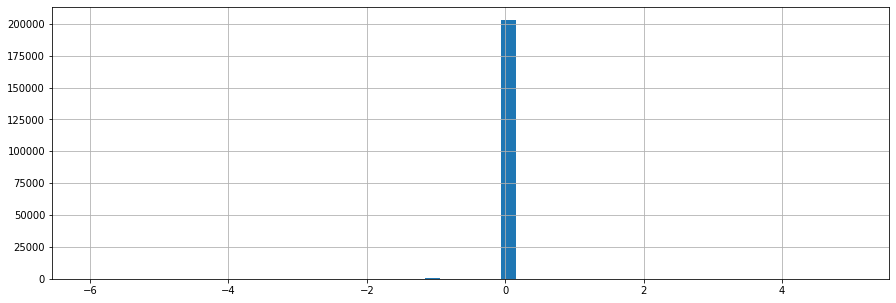

In [24]:

plt.figure(figsize = (15,5))
df_scores = data[
    (~data['nutriscore_score'].isna()) & (~data['nutrition-score-fr_100g'].isna())]

plt.hist(df_scores['nutriscore_score'] - df_scores['nutrition-score-fr_100g'], bins = 50)
plt.grid(True)
plt.show()

In [25]:
# Comparaison of nutriscore and nutrition score
list_delta = pd.DataFrame((data['nutriscore_score']-data['nutrition-score-fr_100g']).abs().value_counts()).sort_index()
list_delta

,0
0.0,202997
1.0,263
2.0,1
3.0,3
4.0,1
5.0,4
6.0,4


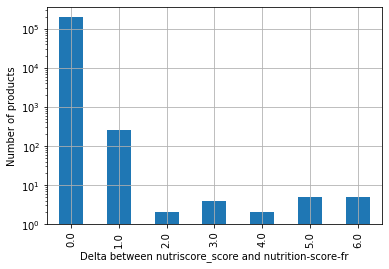

In [26]:
# Distribution of deltas
list_delta.plot(kind = 'bar', log = True)

plt.xlabel("Delta between nutriscore_score and nutrition-score-fr")
plt.ylabel("Number of products")
plt.gca().legend().set_visible(False)
plt.grid(True)
plt.show()

In [27]:
# Products where nutriscore and french nutrition score are differents
data[
    (data['nutriscore_score'] != data['nutrition-score-fr_100g']) & 
    (~data['nutriscore_score'].isna()) & (~data['nutrition-score-fr_100g'].isna())][
    ['product_name','categories', 'nutriscore_score', 'nutrition-score-fr_100g']
].sample(10)

,product_name,categories,nutriscore_score,nutrition-score-fr_100g
435192,Thé vert de Noël,Boissons,0.0,1.0
317288,Chipolatas,"Viandes, Charcuteries, Saucisses, Saucisses fr...",12.0,13.0
1075748,Oolong Tea In Plastic Bottle,"Beverages,Non-Alcoholic beverages",0.0,1.0
379460,Programe 14 jours Drenage,Boissons,2.0,3.0
807695,Leopard Natural,Boissons,13.0,14.0
359781,Banzai noodle,"Plats à base de pâtes,Plats préparés déshydratés",10.0,11.0
853635,Takis Fuego 56GR.,"Snacks, Snacks salés, Apéritif, Chips et frite...",18.0,19.0
646837,Yaourt fermier arôme café,"Produits laitiers, Produits fermentés, Produit...",3.0,4.0
529875,Huile vierge de noix de coco,Matières grasses,19.0,18.0
519960,Yaourt abricot,"Produits laitiers, Produits fermentés, Produit...",3.0,4.0


In [28]:
# Products where nutriscore and french nutrition score are the most differents
data[
    ((data['nutriscore_score']-data['nutrition-score-fr_100g']).abs() > 1) & 
    (~data['nutriscore_score'].isna()) & (~data['nutrition-score-fr_100g'].isna())][
    ['product_name','categories', 'nutriscore_score', 'nutrition-score-fr_100g', 'nutriscore_grade']
]

,product_name,categories,nutriscore_score,nutrition-score-fr_100g,nutriscore_grade
85876,Cheerios Miel & Noix,"Aliments et boissons à base de végétaux, Alime...",1.0,6.0,b
339556,cabre d'or,"Fromages à tartiner,Fromages de chèvre,Fromage...",13.0,9.0,d
356651,Gervita noix de coco,"Produits laitiers, Produits fermentés, Dessert...",12.0,9.0,d
367288,Kiri,"Produits laitiers,Desserts,Desserts lactés,Fro...",19.0,14.0,e
384163,Kidiboo,"Produits laitiers,Produits fermentés,Desserts,...",18.0,15.0,d
384164,Kidiboo,"Produits laitiers, Produits fermentés, Dessert...",17.0,14.0,d
392996,"Anchois (Égouttés Solides dans l'Huile, Conser...",Filets d'anchois marinés à l'huile végétale,2.0,8.0,b
454757,Filets d'anchois marinés au naturel,"Produits de la mer, Poissons, Filets de poisso...",5.0,11.0,c
541753,Jus d'Herbe de Blé,"Boissons, Compléments alimentaires",0.0,6.0,b
569252,Fromage blanc fondu 30% Mat. Gr. x 8,"Produits laitiers, Desserts, Produits fermenté...",18.0,13.0,d


French nutrition score and nutriscore score do correspond in most cases, and look very close when a difference occur.

### French nutrition score vs UK nutrition score

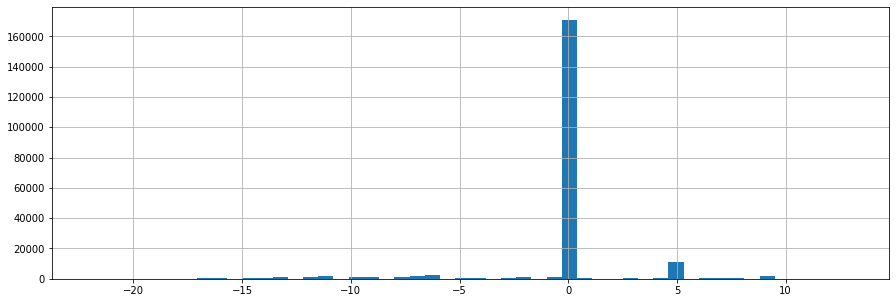

In [29]:
# Comparaison of english and french nutrition scores
plt.figure(figsize = (15,5))
df_scores = data[
    (~data['nutrition-score-uk_100g'].isna()) & (~data['nutrition-score-fr_100g'].isna())]

plt.hist(df_scores['nutrition-score-uk_100g'] - df_scores['nutrition-score-fr_100g'], bins = 50)
plt.grid(True)
plt.show()

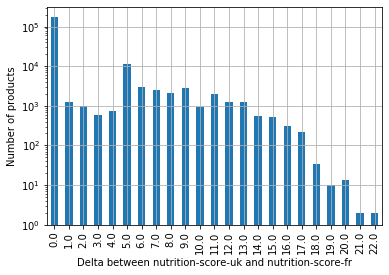

In [30]:
# Distribution of deltas
list_delta2 = pd.DataFrame((data['nutrition-score-uk_100g']-data['nutrition-score-fr_100g']).abs().value_counts()).sort_index()
list_delta2.plot(kind = 'bar', log = True)

plt.xlabel("Delta between nutrition-score-uk and nutrition-score-fr")
plt.ylabel("Number of products")
plt.gca().legend().set_visible(False)
plt.grid(True)
plt.show()

In [31]:
# Comparaison of uk nutrition score and fr nutrition score
(data['nutrition-score-uk_100g']-data['nutrition-score-fr_100g']).abs().value_counts()

0.0     170835
5.0      11388
6.0       2916
9.0       2799
7.0       2446
8.0       2149
11.0      1944
12.0      1284
13.0      1281
1.0       1257
2.0        986
10.0       913
4.0        724
3.0        572
14.0       554
15.0       510
16.0       312
17.0       222
18.0        32
20.0        12
19.0         9
22.0         1
21.0         1
dtype: int64

In [32]:
# Products where english and french nutrition score are the most differents
data[
    ((data['nutrition-score-uk_100g']-data['nutrition-score-fr_100g']).abs() > 10) & 
    (~data['nutrition-score-uk_100g'].isna()) & (~data['nutrition-score-fr_100g'].isna())][
    ['product_name','main_category','categories', 'nutrition-score-uk_100g', 'nutrition-score-fr_100g', 'nutriscore_grade']
].sample(20)

,product_name,main_category,categories,nutrition-score-uk_100g,nutrition-score-fr_100g,nutriscore_grade
430582,Nectar Orange,en:fruit-juices-and-nectars,Nectars d'orange,4.0,19.0,e
543609,Jus de pomme Breavoine bocal 1 litre,en:beverages,Boissons,2.0,14.0,e
809503,Sprite,en:beverages,"Getränke, Kohlensäurehaltige Getränke, Erfrisc...",2.0,13.0,e
665,7Up,en:beverages,"Aliments et boissons à base de végétaux, Boiss...",2.0,13.0,e
413114,Nectar Multifruits,en:beverages,fr:Nectars multifruits,2.0,16.0,e
405016,Nectar à base de purée Abricot du Roussillon,en:fruit-juices-and-nectars,"Boissons, Aliments et boissons à base de végét...",3.0,19.0,e
326792,Tonic Water,en:beverages,"Boissons, Boissons gazeuses, Sodas, Boissons a...",1.0,12.0,e
634352,Limonade,en:beverages,"Boissons, Boissons gazeuses, Sodas, Limonades,...",2.0,13.0,e
809538,Minute Maid,en:beverages,Boissons,3.0,19.0,e
579089,Cocktail orange carotte citron,en:beverages,"Boissons, Boissons avec sucre ajouté",2.0,14.0,e


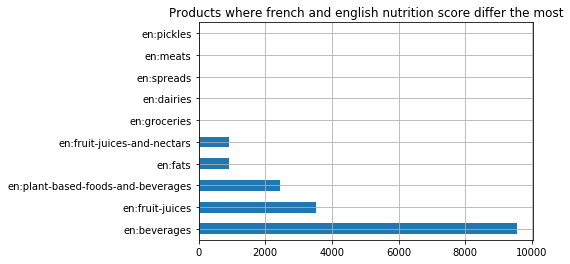

In [33]:
# Categories of product with highest nutrition score delta
data[
    ((data['nutrition-score-uk_100g']-data['nutrition-score-fr_100g']).abs() > 5) & 
    (~data['nutrition-score-uk_100g'].isna()) & (~data['nutrition-score-fr_100g'].isna())]['main_category'].value_counts().plot(kind = 'barh')

plt.title("Products where french and english nutrition score differ the most")
plt.grid(True)
plt.show()

Main differences between the two nutriscore system look to be on how to consider liquid products (beverages and juices)

# Criteria taken into account for calculation of the nutriscore

Source : https://www.santepubliquefrance.fr/media/files/02-determinants-de-sante/nutrition-et-activite-physique/nutri-score/qr-scientifique-technique-en

## Energy

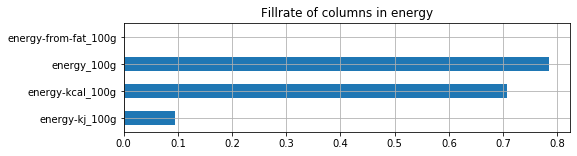

In [34]:
# Columns related to energy
list_criteria(data, 'energy', h_size = 8)

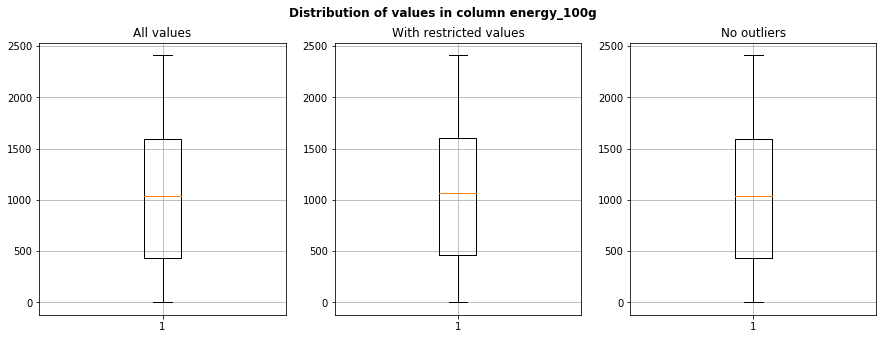

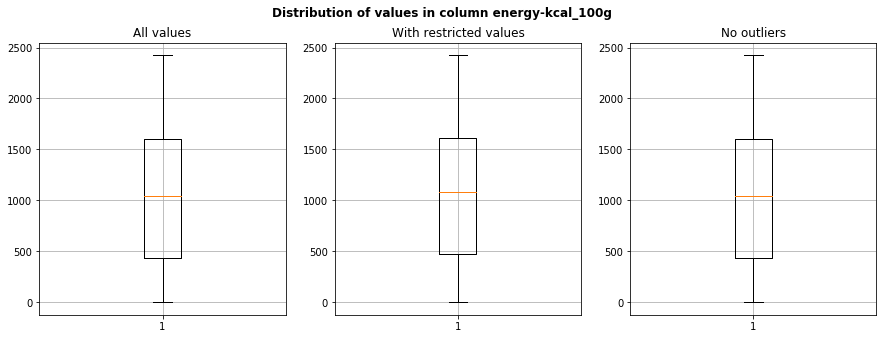

In [35]:
# Distribution of values
from PSanté_01_scripts import both_boxplot
both_boxplot(data, 'energy_100g', up_bound = 20000)
both_boxplot(data, 'energy-kcal_100g', up_bound = 20000)

In [36]:
# Highest values
from PSanté_01_scripts import higher_values
higher_values(data, 'energy_100g', 10000, limit = 20)

,product_name,categories,main_category,energy_100g


In [37]:
higher_values(data, 'energy-kcal_100g', 80, limit = 20)

,product_name,categories,main_category,energy-kcal_100g
766038,Marrakesh spicy,NaN,NaN,2423.0
824213,E. Wedel Whole Hazelnuts Luksosowa,NaN,NaN,2423.0
328851,Mini œuf de pâques noir 70%,Œufs de Pâques,en:easter-food,2423.0
882586,Giandor,NaN,NaN,2423.0
882580,Les Délices Blanc Croquant,"Snacks, Snacks sucrés, Chocolats, Chocolats bl...",en:snacks,2423.0
86417,Pate a tartiner bio au cacao et aux noisettes,NaN,NaN,2423.0
1069621,Seasoned Seeaweed,NaN,NaN,2423.0
509244,Tablette Chocolat Au Lait,NaN,NaN,2423.0
806850,Brazil sauce,NaN,NaN,2423.0
900137,"Kinder Moulage Lap.15Gxt6,",NaN,NaN,2423.0


In [38]:
higher_values(data, 'energy-kj_100g', 5000)

,product_name,categories,main_category,energy-kj_100g


### Differences between the energy columns

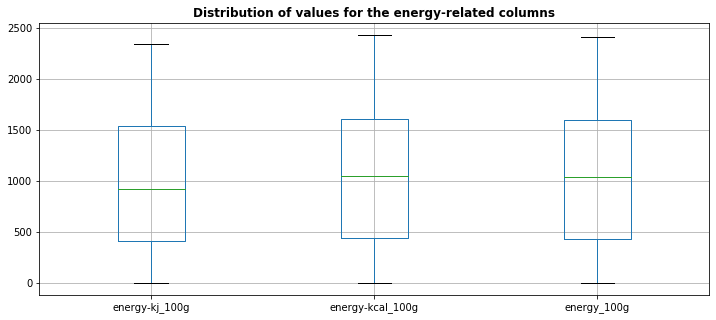

In [39]:
data[['energy-kj_100g','energy-kcal_100g','energy_100g']].boxplot(figsize = (12,5))
plt.title("Distribution of values for the energy-related columns", fontweight = 'bold')
plt.show()

In [40]:
# Statistical description
data[['energy-kj_100g','energy-kcal_100g','energy_100g']].describe()

,energy-kj_100g,energy-kcal_100g,energy_100g
count,51841.000000,388704.000000,431466.000000
mean,998.272297,1056.978956,1051.168074
std,663.161277,685.531175,683.533742
min,0.000000,0.000000,0.000000
25%,412.000000,435.000000,431.000000
50%,920.000000,1046.000000,1037.000000
75%,1531.000000,1602.000000,1594.000000
max,2342.000000,2423.000000,2410.000000


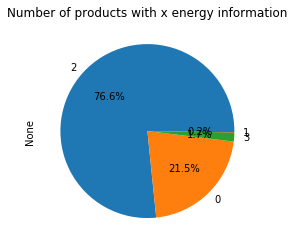

In [41]:
# Number of filled energy columns per products
data[['energy-kj_100g','energy-kcal_100g','energy_100g']].count(axis = 1).value_counts().plot(
    kind = 'pie', autopct = lambda x: str(round(x, 1)) + '%')
plt.title("Number of products with x energy information")
plt.show()

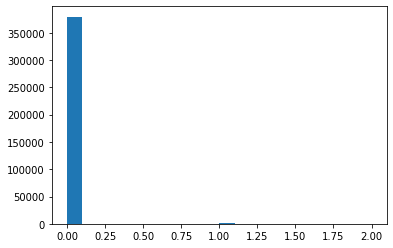

In [42]:
# relation between energy_100g and energy-kcal_100g
test = (data['energy-kcal_100g'] - data['energy_100g']).dropna().to_list()
plt.hist(test, range = (0, 2), bins = 20)
plt.show()

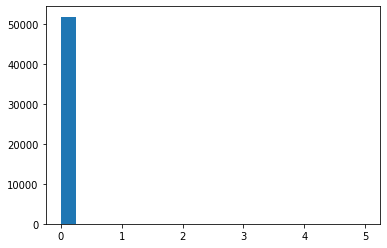

In [43]:
test = (data['energy-kj_100g'] - data['energy_100g']).dropna().to_list()
plt.hist(test, range = (0, 5), bins = 20)
plt.show()

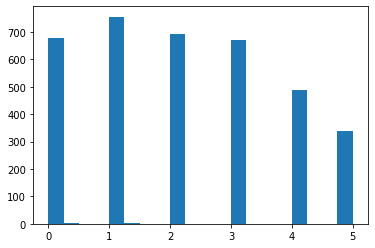

In [44]:
# relation between energy-kj_100g and energy-kcal_100g
test = (data['energy-kj_100g'] - data['energy-kcal_100g']).dropna().to_list()
plt.hist(test, range = (0, 5), bins = 20)
plt.show()

In [45]:
# Correlation matrix
data[['energy_100g','energy-kcal_100g','energy-kj_100g']].corr(method = 'pearson')

,energy_100g,energy-kcal_100g,energy-kj_100g
energy_100g,1.000000,0.999835,1.000000
energy-kcal_100g,0.999835,1.000000,0.992549
energy-kj_100g,1.000000,0.992549,1.000000


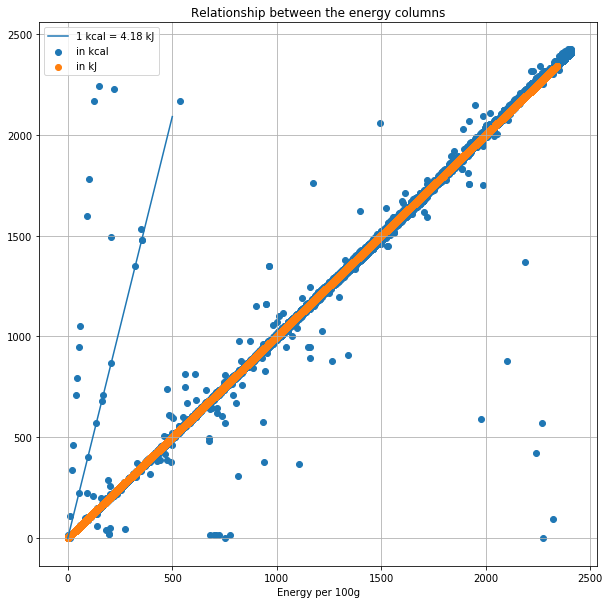

In [46]:
# plotting energy data
plt.figure(figsize = (10,10))

plt.plot([0,500],[0, 500*4.18])
plt.scatter(data['energy_100g'], data['energy-kcal_100g'])
plt.scatter(data['energy_100g'], data['energy-kj_100g'])

plt.legend(["1 kcal = 4.18 kJ", "in kcal", "in kJ"], loc = 'best')

plt.title("Relationship between the energy columns")
plt.xlabel('Energy per 100g')

plt.grid(True)
plt.show()

In [47]:
import statsmodels.api as sm

Y = data['energy_100g']
X = data[['energy-kcal_100g']].copy()
X['intercept'] = 1.
sm.OLS(Y, X, missing = 'drop').fit().params

energy-kcal_100g    0.999811
intercept           0.204572
dtype: float64

In [48]:
Y = data['energy_100g']
X = data[['energy-kj_100g']].copy()
X['intercept'] = 1.
sm.OLS(Y, X, missing = 'drop').fit().params

energy-kj_100g    1.000000e+00
intercept         3.552714e-14
dtype: float64

In [49]:
Y = data['energy-kj_100g']
X = data[['energy-kcal_100g']].copy()
X['intercept'] = 1.
sm.OLS(Y, X, missing = 'drop').fit().params

energy-kcal_100g    0.991760
intercept           8.470536
dtype: float64

Information about energy is provided by the dataset, and availiable for a large amount of entries in the dataset.
However, the distributions shall be closely checked because of the numerous outliers, and because of the relationship between kcal and kj, which shall be approximately 1 kcal = 4.18 kJ

The columns energy_100g clearly corresponds to the energy measured in kj

In [50]:
# Completing missing data in energy with energy-kj
data[(data['energy_100g'].isna()) & (~data['energy-kj_100g'].isna())][['energy_100g','energy-kj_100g']]

,energy_100g,energy-kj_100g


### Statistical tests

In [51]:
# t-test for population with equal variances
import scipy.stats as ssta
ssta.bartlett(data['energy_100g'],data['energy-kj_100g'])

BartlettResult(statistic=503.5209382636136, pvalue=1.6288853396210688e-111)

In [52]:
# t-test for population with equal mean
ssta.ttest_ind(data['energy_100g'], data['energy-kj_100g'], equal_var=True, nan_policy = 'omit')

Ttest_indResult(statistic=16.700577935099997, pvalue=1.3516780873957261e-62)

In [53]:
# t-test for energy and energy_kcal
(ssta.bartlett(data['energy_100g'],data['energy-kcal_100g']), 
ssta.ttest_ind(data['energy_100g'], data['energy-kcal_100g'], equal_var=True, nan_policy = 'omit'))

(BartlettResult(statistic=4.683442202254133, pvalue=0.030454665367921574),
 Ttest_indResult(statistic=-3.8389406104302632, pvalue=0.0001235755789009604))

In [54]:
format(ssta.ttest_ind(data['energy_100g'], data['energy-kcal_100g'], equal_var=True, nan_policy = 'omit')[1], '0.2E')

'1.24E-04'

## Saturated fat acids

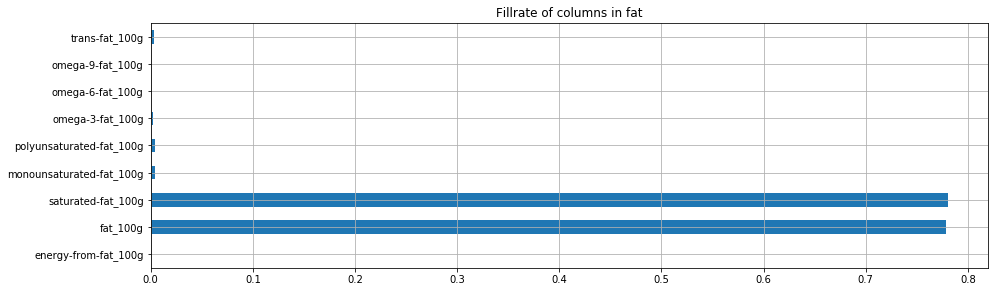

In [55]:
# Columns containing information about fats
list_criteria(data, 'fat')

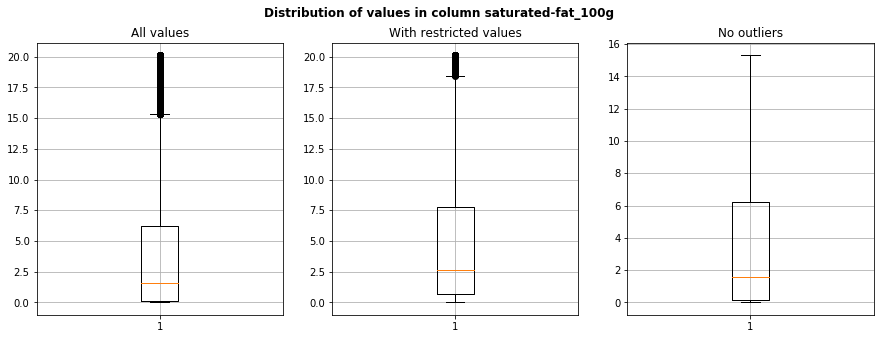

,product_name,categories,main_category,saturated-fat_100g


In [56]:
both_boxplot(data, 'saturated-fat_100g', up_bound = 100)
higher_values(data, 'saturated-fat_100g', 80, limit = 20)

## Fruits and vegetables

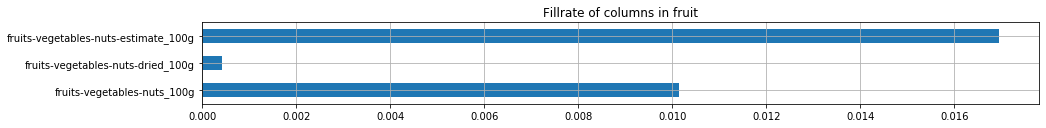

In [57]:
list_criteria(data, 'fruit')

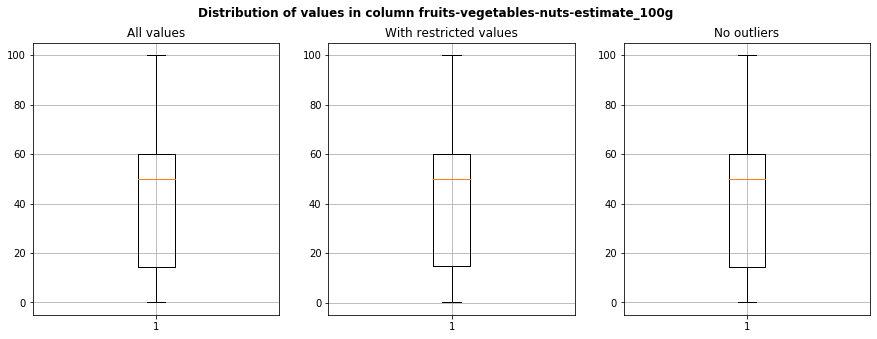

,product_name,categories,main_category,fruits-vegetables-nuts-estimate_100g
415835,Pomme sans sucres ajoutés,"Aliments et boissons à base de végétaux, Alime...",en:plant-based-foods-and-beverages,99.9
473962,Jus de pommes,Jus de pomme,en:fruit-juices,99.9
473965,Jus de fruits Pomme cassis,"Aliments et boissons à base de végétaux,Boisso...",en:fruit-juices,99.9
353610,Pomme Coing sans sucres ajoutés,"Aliments et boissons à base de végétaux, Alime...",en:plant-based-foods-and-beverages,99.9
526287,Gourdes Minute Fruitée Quetsche Pomme,"Aliments et boissons à base de végétaux, Alime...",en:plant-based-foods-and-beverages,99.9
559830,Compote de pomme bio,"Aliments et boissons à base de végétaux, Alime...",en:plant-based-foods-and-beverages,99.9
560545,Pomme à la Cannelle,"Boissons, Boissons sans sucre ajouté",en:beverages,99.9
279226,Pom' & Go Pomme,"Aliments et boissons à base de végétaux,Alimen...",en:plant-based-foods-and-beverages,99.9
560714,Jus Multifruits,"Boissons, Aliments et boissons à base de végét...",en:fruit-juices,99.9
560989,Compote de pommes et poires,"Plant-based foods and beverages,Plant-based fo...",en:plant-based-foods-and-beverages,99.9


In [58]:
both_boxplot(data, 'fruits-vegetables-nuts-estimate_100g', up_bound = 100)
higher_values(data, 'fruits-vegetables-nuts-estimate_100g', 80, limit = 20)

In [59]:
data[~data['fruits-vegetables-nuts-estimate_100g'].isna()]['pnns_groups_1'].unique()

array(['Composite foods', 'Fruits and vegetables', 'unknown',
       'Sugary snacks', 'Beverages', 'Fat and sauces', 'Salty snacks',
       'sugary-snacks', 'Milk and dairy products', 'Cereals and potatoes',
       'Fish Meat Eggs', 'fruits-and-vegetables', nan,
       'cereals-and-potatoes'], dtype=object)

In [60]:
data[data['fruits-vegetables-nuts-estimate_100g'].isna()]['pnns_groups_1'].unique()

array(['unknown', 'Fat and sauces', 'Composite foods', 'Sugary snacks',
       'Fruits and vegetables', 'Fish Meat Eggs',
       'Milk and dairy products', 'Cereals and potatoes', 'Beverages',
       nan, 'Salty snacks', 'sugary-snacks', 'fruits-and-vegetables',
       'cereals-and-potatoes', 'salty-snacks'], dtype=object)

For this criteria, given in percentage, small part of the dataset has information. However, data is given of a large amount of data, and estimations could be calculated for products that are susceptible to contain fruits or vegetables

## Sodium

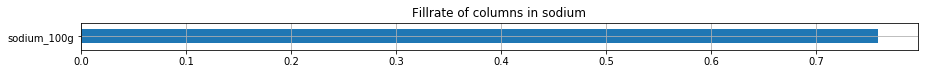

In [61]:
list_criteria(data, 'sodium')

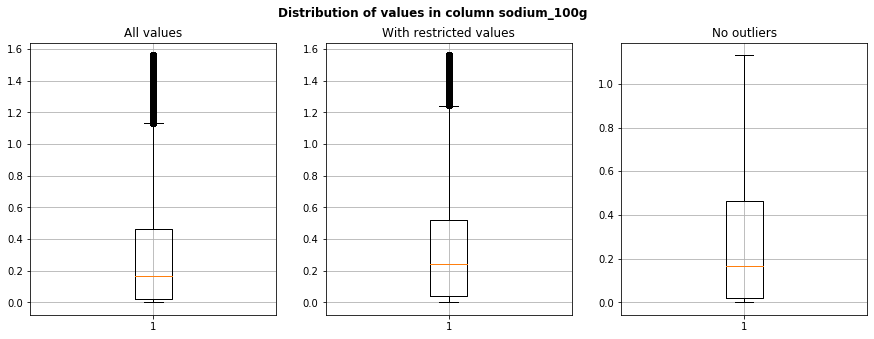

,product_name,categories,main_category,sodium_100g


In [62]:
# Distribution of values & highest values for sodium
both_boxplot(data, 'sodium_100g', up_bound = 100)
higher_values(data, 'sodium_100g', 50, limit = 20)

## Sugar

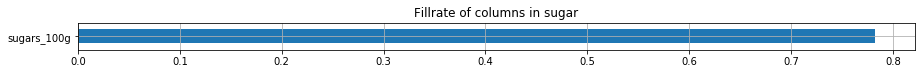

In [63]:
list_criteria(data, 'sugar')

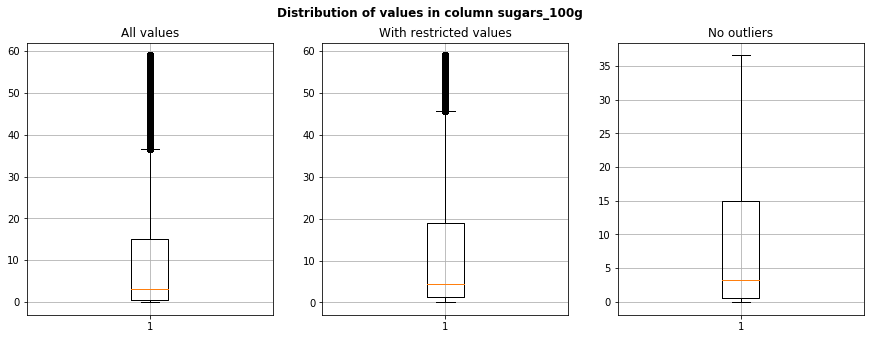

,product_name,categories,main_category,sugars_100g
598228,Confiture Extra De Framboise,"Aliments et boissons à base de végétaux, Alime...",en:plant-based-foods-and-beverages,59.0
586057,Larvasss Acid,NaN,NaN,59.0
568128,Cappuccino nature + poudreuse chocolat,"Boissons, Boissons chaudes, Boissons instantan...",en:beverages,59.0
568257,Mélange graines ananas raisins,NaN,NaN,59.0
569522,Confiture fraise et fruit de la passion,"Aliments et boissons à base de végétaux, Alime...",en:plant-based-foods-and-beverages,59.0
570893,Confiture orange,"Aliments et boissons à base de végétaux, Alime...",en:plant-based-foods-and-beverages,59.0
571062,Confiture extra fraise bio,"Aliments et boissons à base de végétaux, Alime...",en:plant-based-foods-and-beverages,59.0
571428,Confiture cerises bio,"Aliments et boissons à base de végétaux, Alime...",en:plant-based-foods-and-beverages,59.0
571715,Nougat de Montélimar tendre,"Snacks, Snacks sucrés, Confiseries, Confiserie...",en:snacks,59.0
575572,Pop Corn Caramel,"Snacks,Snacks sucrés,Popcorn,Popcorn sucré",en:snacks,59.0


In [64]:
# Distribution of values & highest values for sodium
both_boxplot(data, 'sugars_100g', up_bound = 100)
higher_values(data, 'sugars_100g', 50, limit = 10)

## Proteins

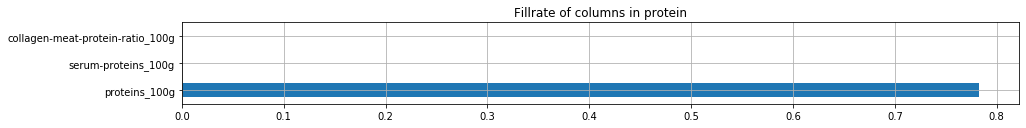

In [65]:
# Looking for columns related to proteins
list_criteria(data, 'protein')

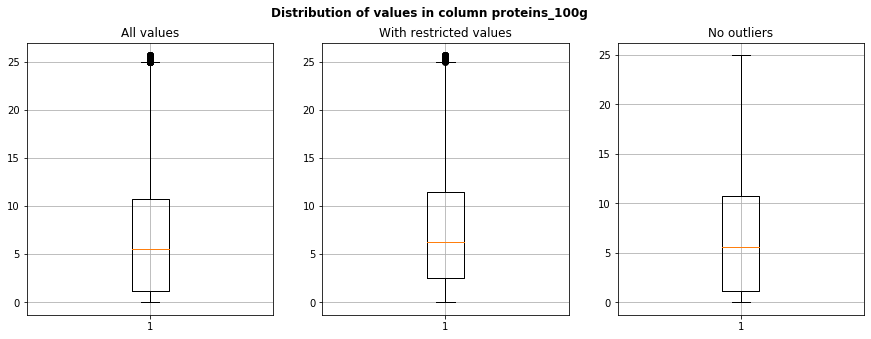

,product_name,categories,main_category,proteins_100g


In [66]:
# Distribution of values & highest values for proteins
both_boxplot(data, 'proteins_100g', up_bound = 100)
higher_values(data, 'proteins_100g', 50, limit = 10)

## Fiber

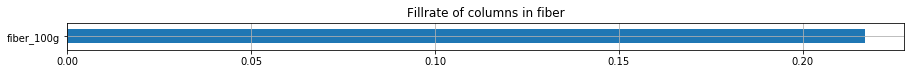

In [67]:
list_criteria(data, 'fiber')

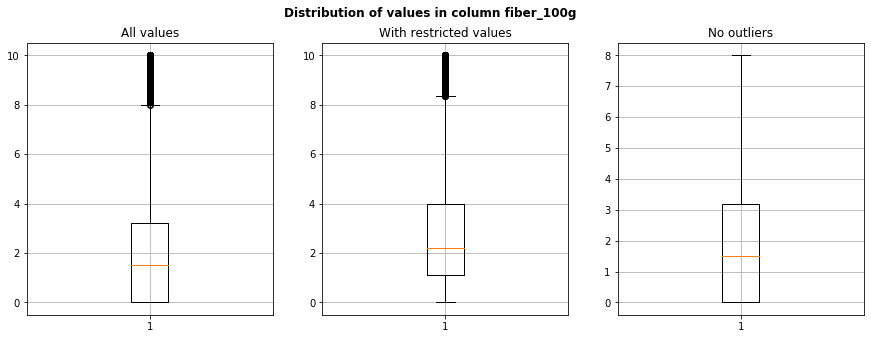

,product_name,categories,main_category,fiber_100g


In [68]:
# Distribution of values & highest values for fibers
both_boxplot(data, 'fiber_100g', up_bound = 100)
higher_values(data, 'fiber_100g', 50, limit = 10)

## Salt

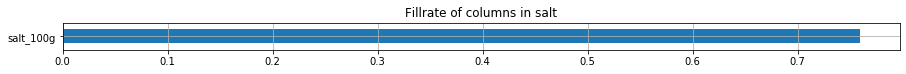

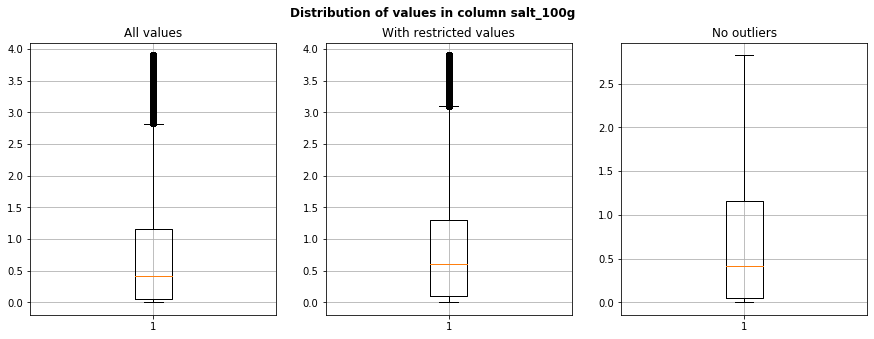

,product_name,categories,main_category,salt_100g


In [69]:
list_criteria(data, 'salt')
both_boxplot(data, 'salt_100g', up_bound = 100)
higher_values(data, 'salt_100g', 100, limit = 20)

# Relation of each criteria with nutrition score

## Criteria vs NS

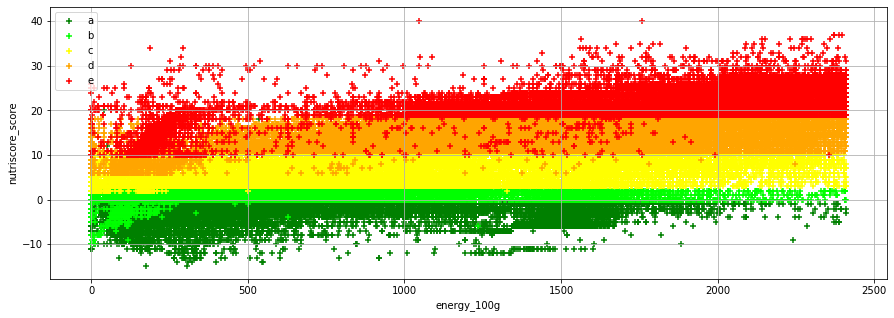

In [70]:
# Plotting nutrition-score versus energy
from PSanté_01_scripts import plot_score
plot_score(data,'energy_100g', 'nutriscore_score')

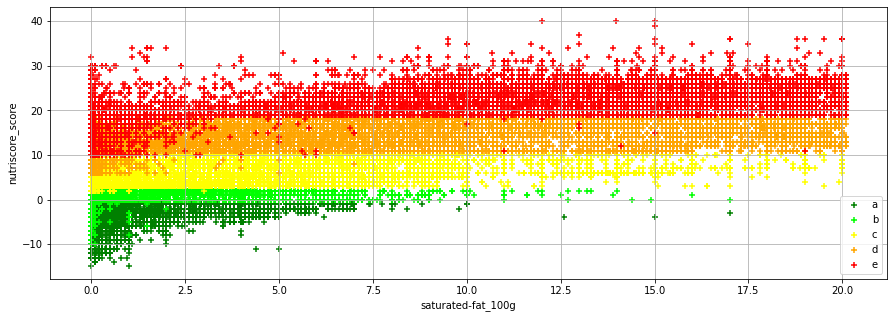

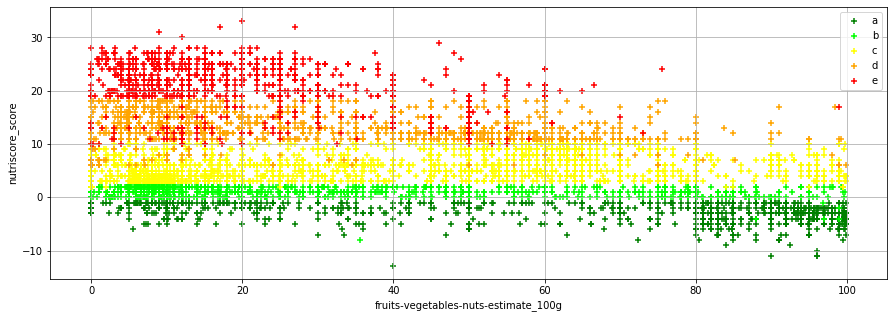

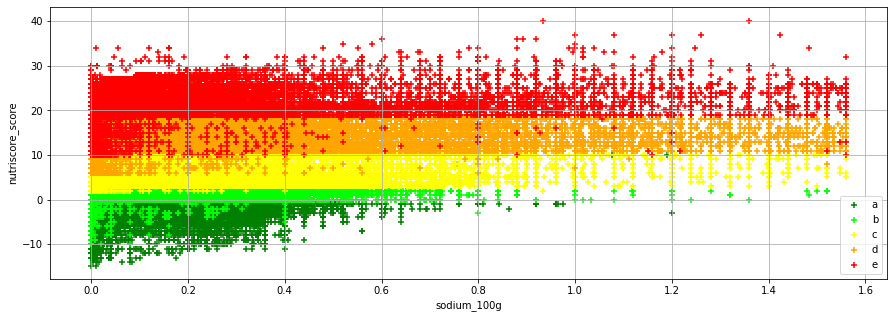

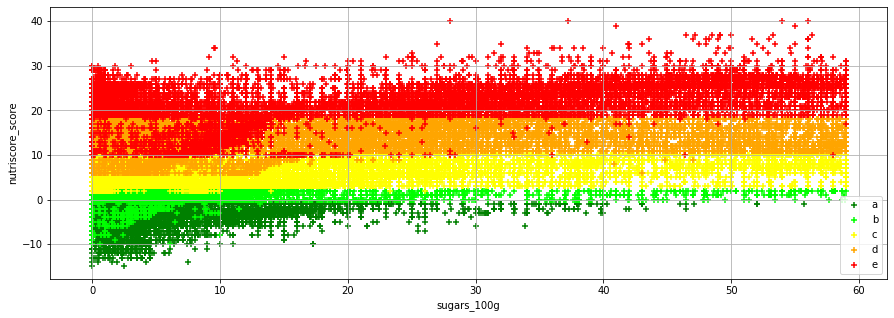

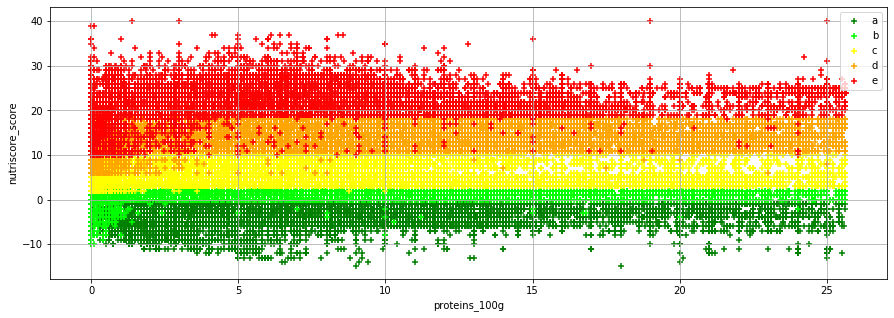

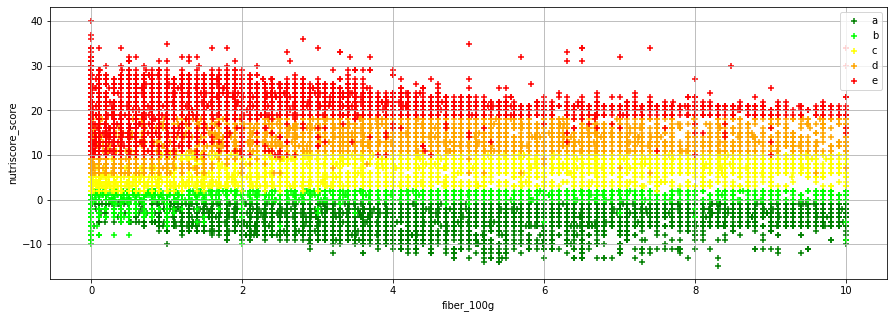

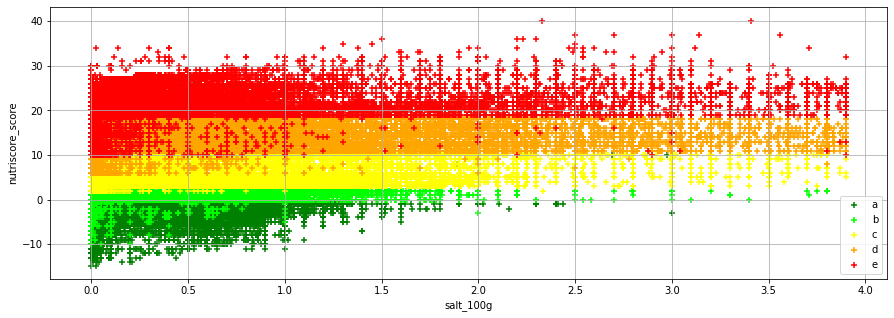

In [71]:
# Plotting nutrition score versus all other criteria
for criteria in ['saturated-fat_100g',
                 'fruits-vegetables-nuts-estimate_100g',
                 'sodium_100g',
                 'sugars_100g',
                 'proteins_100g',
                 'fiber_100g',
                 'salt_100g'] :
    plot_score(data,criteria, 'nutriscore_score')

In [72]:
data[gr_nutriscore].corr(method = 'pearson')[['nutriscore_score']]

,nutriscore_score
nutriscore_score,1.000000
energy_100g,0.645569
saturated-fat_100g,0.654672
fruits-vegetables-nuts-estimate_100g,-0.254033
sodium_100g,0.283161
sugars_100g,0.419206
proteins_100g,0.036918
fiber_100g,-0.159753
salt_100g,0.283158


## Relations between NS criteria

In [73]:
# Pairplot between nutriscore criteria
df_nutriscore = data[[
    'nutriscore_grade', 'energy_100g', 'saturated-fat_100g','fruits-vegetables-nuts_100g', 'sodium_100g', 'proteins_100g',
    'sugars_100g', 'fiber_100g', 'salt_100g'
]]

C:\Users\alexa_000\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\alexa_000\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


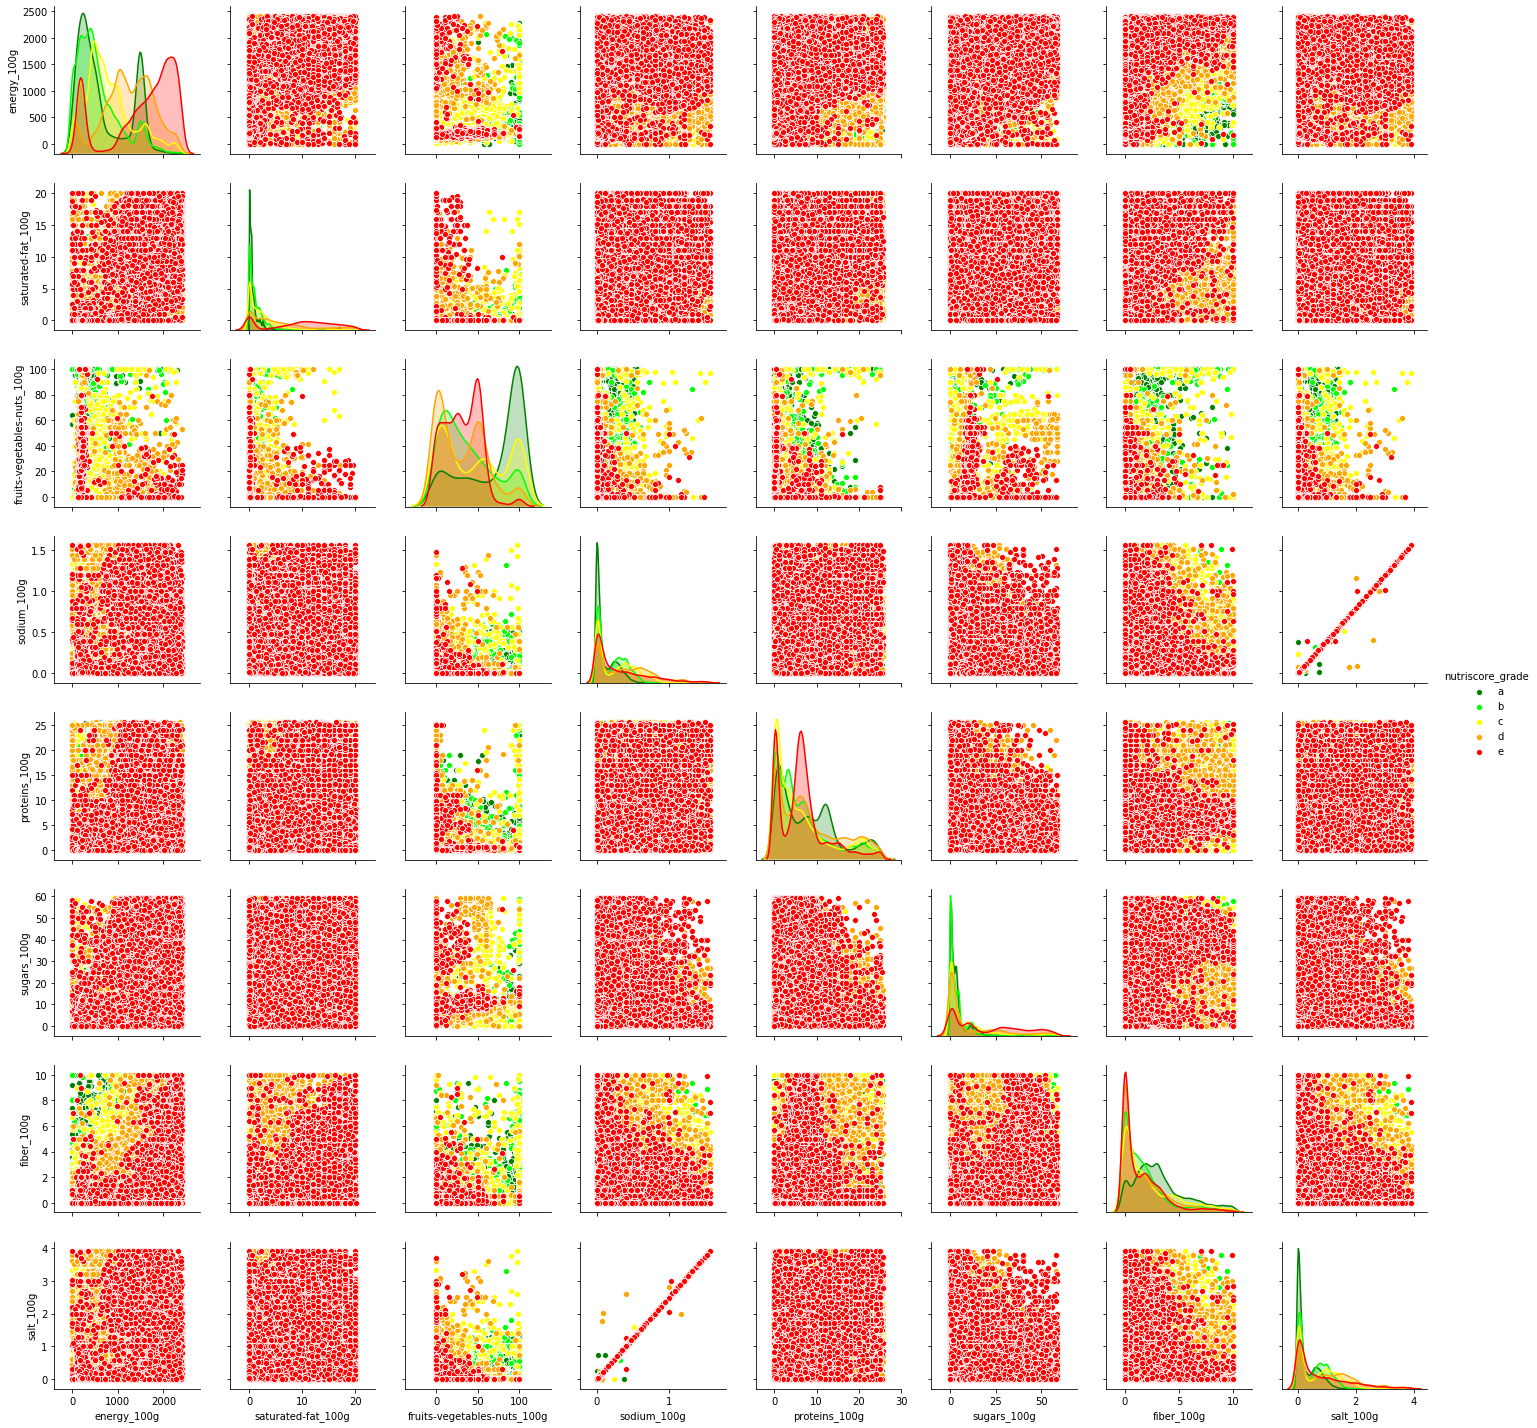

In [74]:
sns.pairplot(df_nutriscore,hue = 'nutriscore_grade', hue_order = df_nutriscore['nutriscore_grade'].sort_values().unique(),
             palette = ['green','lime','yellow','orange','red'])
plt.show()

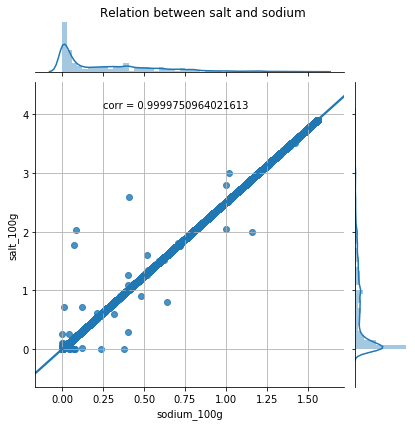

In [75]:
# Correlation between sodium and salt
sns.jointplot("sodium_100g", "salt_100g", data = df_nutriscore, kind = 'reg')
corr = df_nutriscore[['salt_100g','sodium_100g']].corr(method = 'pearson').iloc[0,1]

plt.subplots_adjust(top=0.95)
plt.suptitle("Relation between salt and sodium")
plt.text(0.25, 4.1, "corr = {}".format(corr))
plt.grid(True)
plt.show()

## Relations with other nutriment informations

In [76]:
df_nutriscore[['salt_100g','sodium_100g']].corr(method = 'pearson').iloc[0,1]

0.9999750964021613

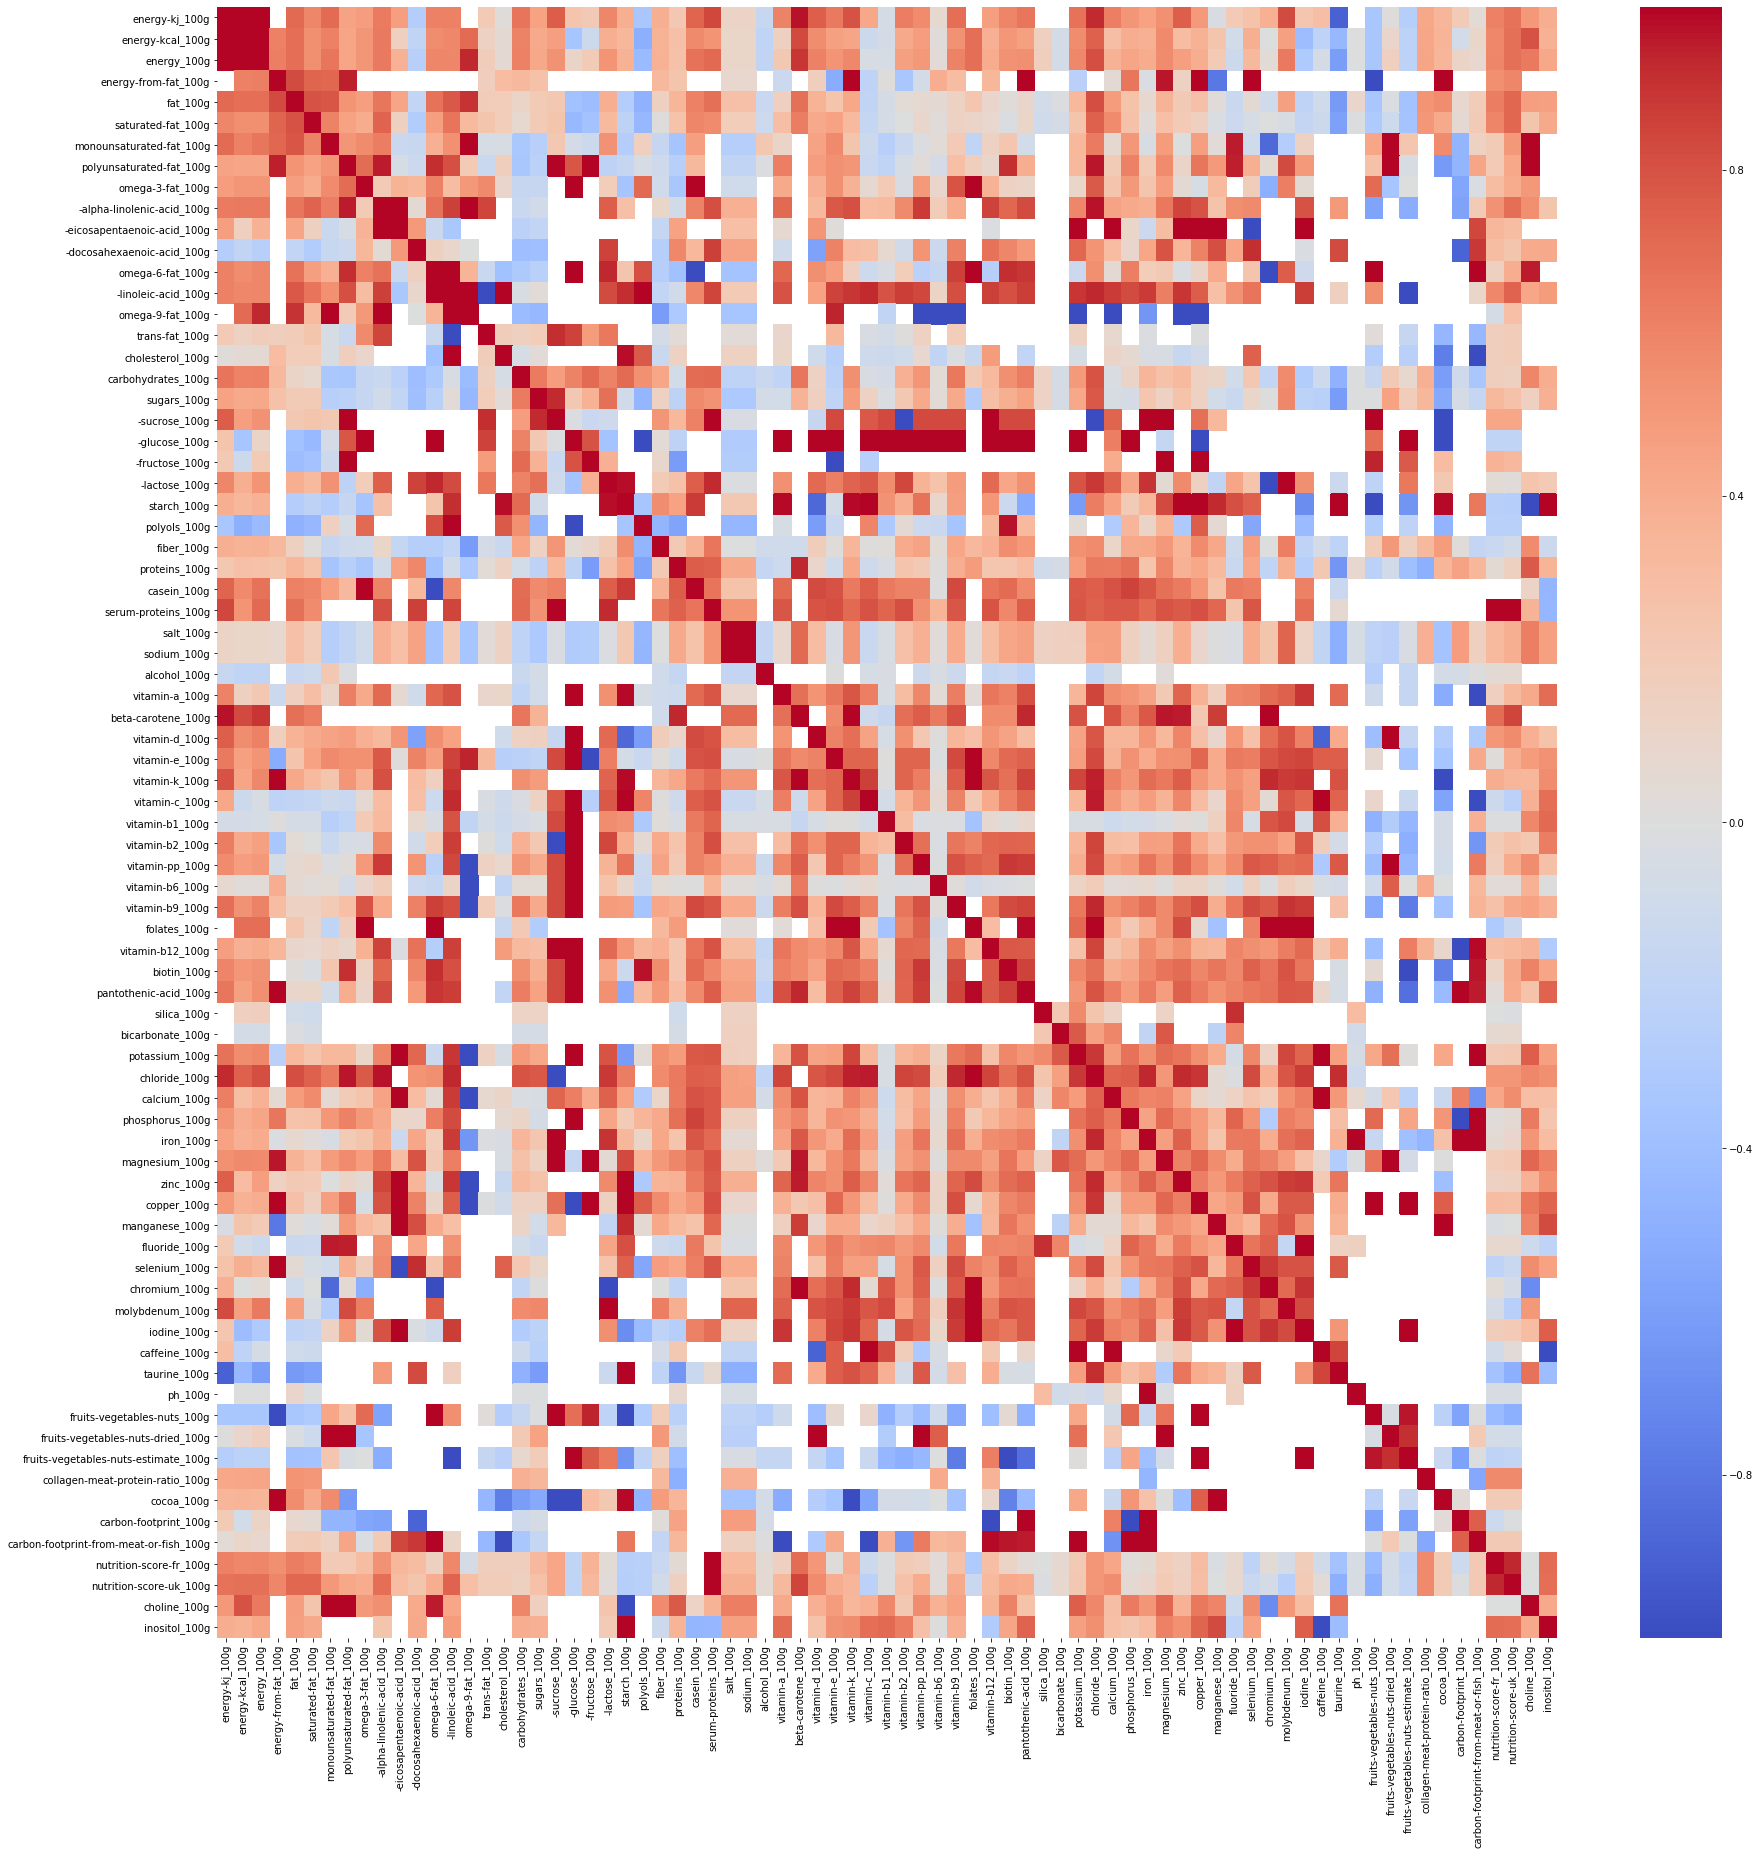

In [77]:
# Correlations between columns
Nutr_facts = [col for col in data.columns if '_100g' in col]

df_corr = data[Nutr_facts].corr(method = 'pearson')

plt.figure(figsize = (30,30))
sns.heatmap(df_corr, cmap = 'coolwarm')
plt.show()

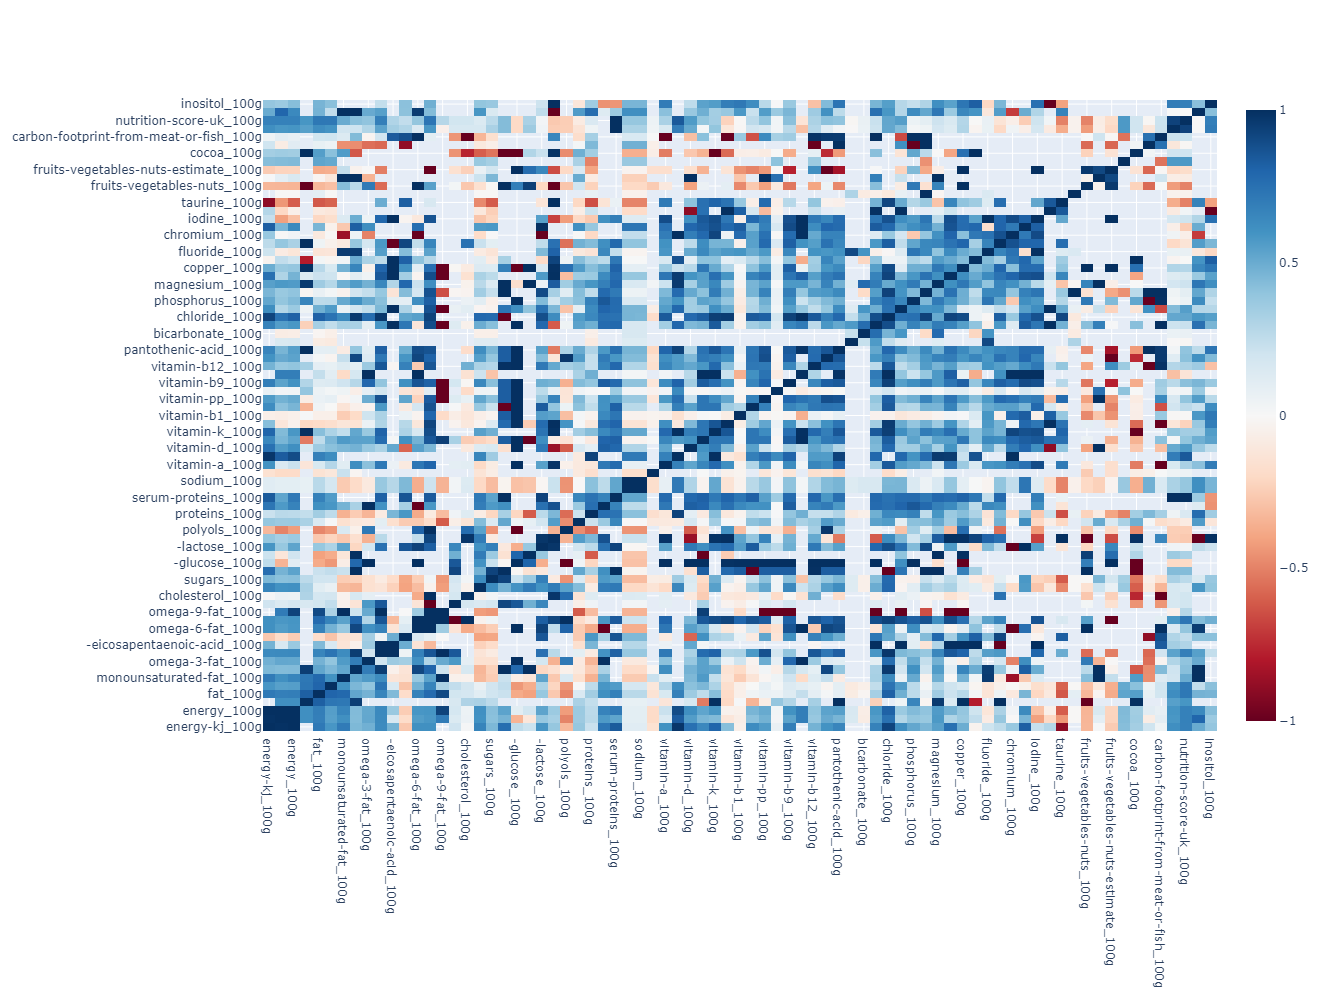

In [83]:
# Correlations between columns
Nutr_facts = [col for col in data.columns if '_100g' in col]
df_corr = data[Nutr_facts].corr(method = 'pearson')

import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(z = df_corr, x = df_corr.columns, y = df_corr.columns, colorscale = 'rdbu'))
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000
)
fig.show()

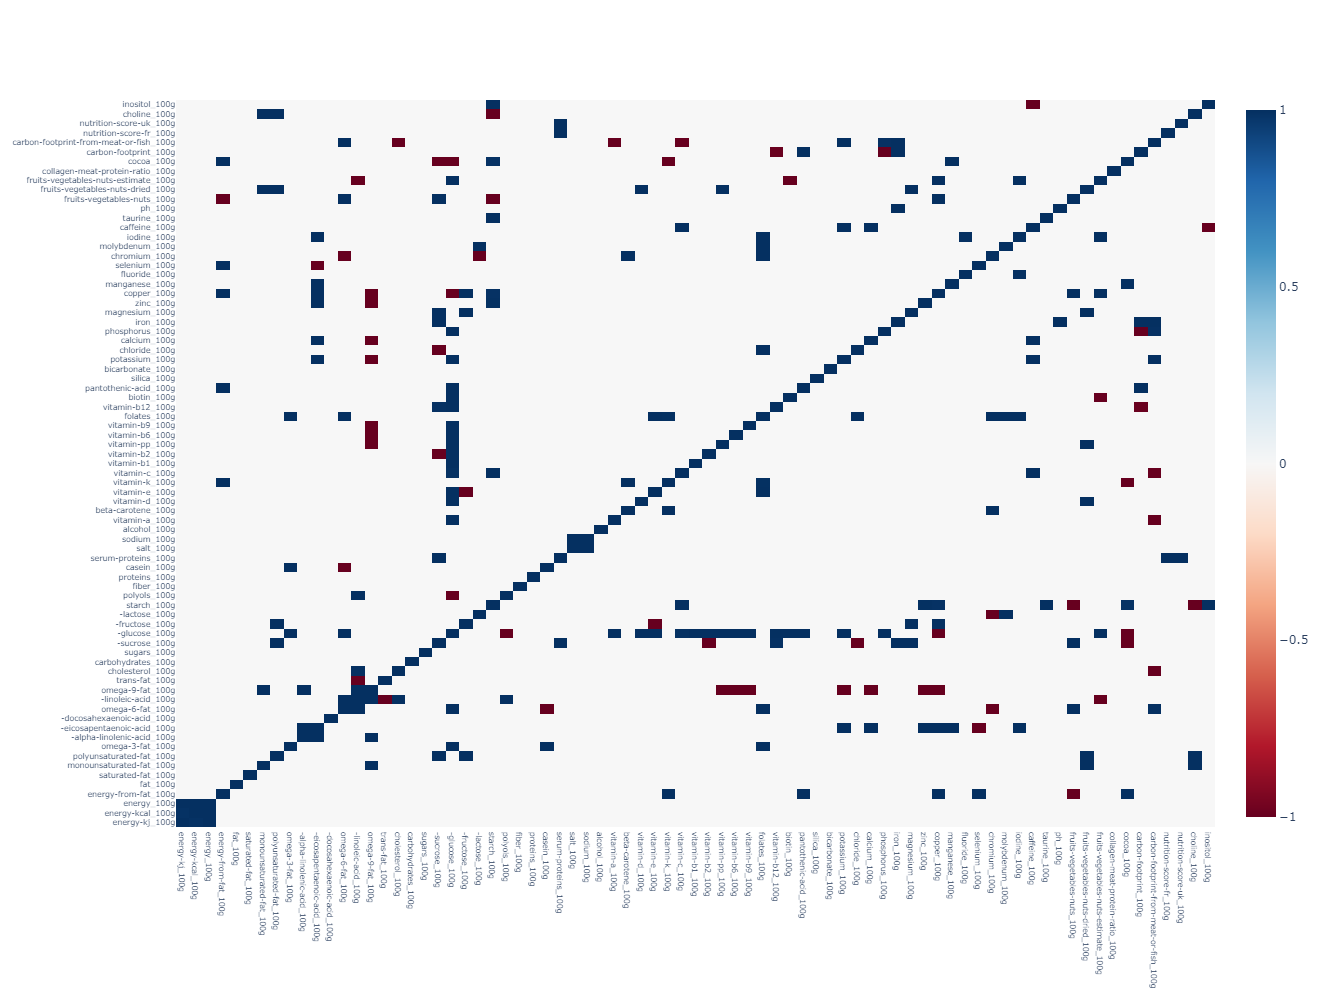

In [99]:
# Enlightening strongest correlations
df_corr_e = df_corr.applymap(lambda x: 0 if abs(x) < 0.99 else x).copy().fillna(0)

fig = go.Figure(data=go.Heatmap(z = df_corr_e, x = df_corr.columns, y = df_corr.columns, colorscale = 'rdbu'))
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000
)
fig.update_xaxes(tickfont = dict(size = 7.5))
fig.update_yaxes(tickfont = dict(size = 7.8))
fig.show()

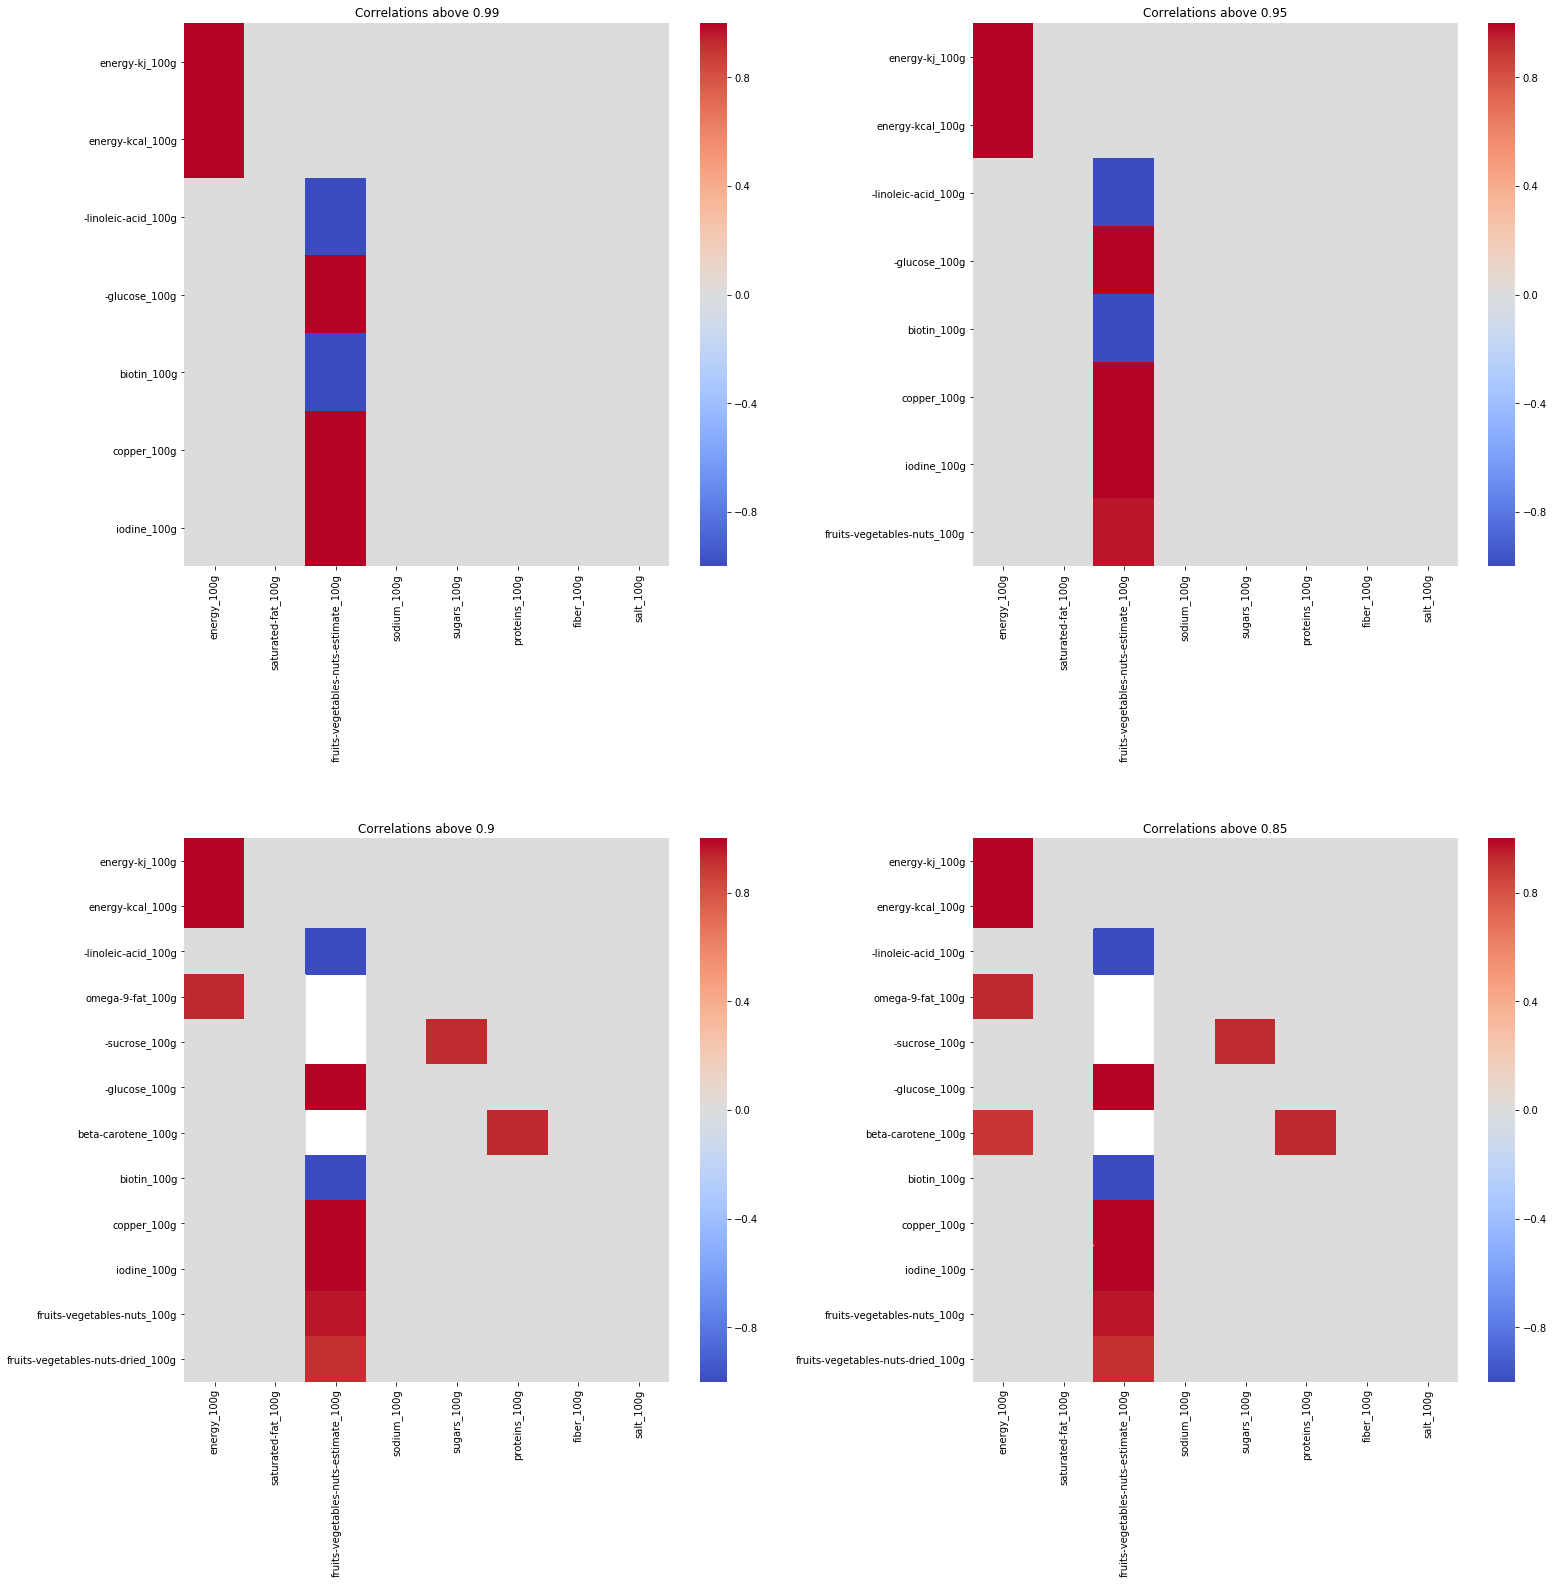

In [103]:
# Correlations for nutriscore criteria
from PSanté_01_scripts import plot_corr
crit = [0.99, 0.95, 0.9, 0.85]
plt.figure(figsize = (25,25))
for i in range(len(crit)):
    plt.subplot(221 + i)
    plt.title("Correlations above {}".format(crit[i]))
    plot_corr(data[Nutr_facts], selection = gr_nutriscore[2:], criteria = crit[i])
    plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

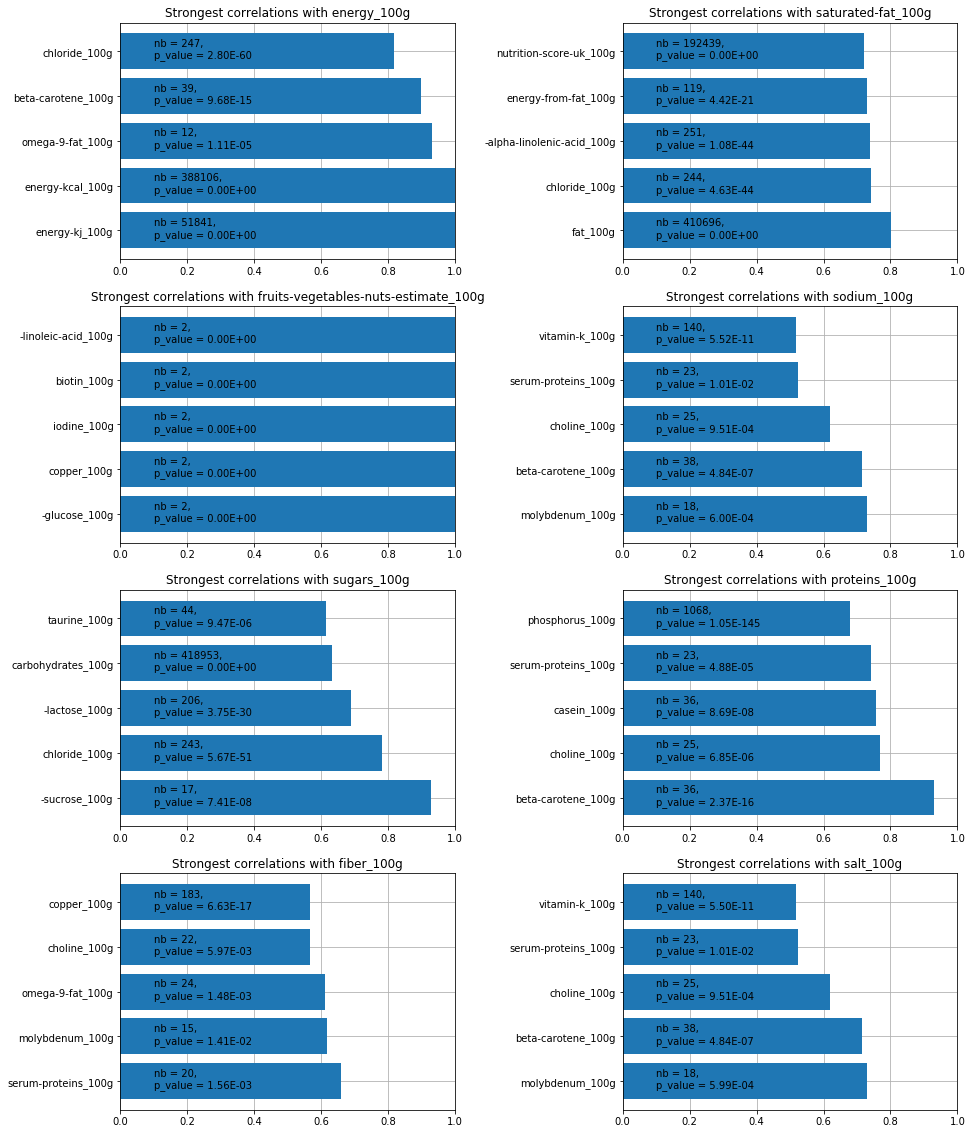

In [81]:
# Columns with strongest correlation for each nutriscore criteria
from scipy.stats import pearsonr

plt.figure(figsize = (15,20))
for crit in gr_nutriscore[2:]:
   
    # Plotting strongest correlations
    df_test = df_corr[[crit]].apply(abs).sort_values(by = crit, ascending = False).drop(index = gr_nutriscore[2:]).head(5)
    plt.subplot(421 + gr_nutriscore[2:].index(crit))
    plt.barh(range(5), df_test[crit], tick_label = df_test.index, zorder = 2)
    plt.xlim(0,1)
    plt.grid(True, zorder = 1)
    plt.subplots_adjust(wspace = 0.5)
    plt.title("Strongest correlations with {}".format(crit))
    
    # Calculating occurences & p-value
    for i in range(5):
        corr = df_test.index[i]
        nb_elements = len(data[(~data[crit].isna()) & (~data[corr].isna())])
        
        df_essai = data[[crit,corr]].dropna()
        p_val = format(pearsonr(df_essai.iloc[:,0], df_essai.iloc[:,1])[1], '0.2E')
        plt.text(0.1, i-0.15, 'nb = {},\np_value = {}'.format(nb_elements, p_val))

plt.show()